Plot APR2 radar data. Only interested in nadir view (Beam # 12 (python # 11)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyart
from pyhdf.SD import SD, SDC
from datetime import datetime, timedelta
from geopy.distance import geodesic
from scipy.ndimage.filters import uniform_filter


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/var/folders/cb/zhyy0qr14kg35txh2x2n3hvm0002n2/T/ipykernel_56304/2712605169.py:9: DeprecationWarning: Please import `uniform_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter


In [2]:
# implement functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

In [3]:
# Load data

Directory = '/Users/hvagasky/Data/PMM_Hail/GRIP/APR2/'
File = 'APR2.100917.163311.26.HDF' # HDF4

hdf = SD(Directory + File, SDC.READ)
print(hdf.datasets().keys()) # prints variables

dbz14 = np.array(hdf.select('zhh14'), dtype=float) 
#ku band (bins, ray, scans) (500, 24, 452), 100 scale factor, 30 m resolution, dbz

dbz35 = np.array(hdf.select('zhh35'), dtype=float) 
#ka band (bins, ray, scans) (500, 24, 452), 100 scale factor, 30 m resolution, dbz

vel14 = np.array(hdf.select('vel14'), dtype=float) 
#velocity from ku - band (bins, ray, scans) (500, 24, 452), 100 scale factor, 30 m resolution, m/s

ldr14 = np.array(hdf.select('ldr14'), dtype=float) 
sigma_zero = np.array(hdf.select('sigma_zero'), dtype=float)
APRspeed = np.array(hdf.select('v_surf'), dtype=float)
Time = np.array(hdf.select('scantime')) # seconds since 1970-1-1 0:0:0
Latitude = np.array(hdf.select('lat3D'))
Longitude = np.array(hdf.select('lon3D'))
Altitude = np.array(hdf.select('alt3D'))
LatOffset = np.array(hdf.select('lat3D_offset'))
LonOffset = np.array(hdf.select('lon3D_offset'))
AltOffset = np.array(hdf.select('alt3D_offset'))
LatScale = np.array(hdf.select('lat3D_scale'))
LonScale = np.array(hdf.select('lon3D_scale'))
AltScale = np.array(hdf.select('alt3D_scale'))



dict_keys(['zhh14', 'ldr14', 'vel14', 'zhh35', 'look_vector', 'sigma_zero', 'range0', 'beamnum', 'isurf', 'sequence', 'v_surf', 'v_surfdc8', 'scantime', 'scantimus', 'alt_nav', 'lat', 'lon', 'alt_radar', 'roll', 'pitch', 'drift', 'look_vector_radar', 'surface_index', 'lat3D_offset', 'lon3D_offset', 'alt3D_offset', 'lat3D_scale', 'lon3D_scale', 'alt3D_scale', 'lat3D', 'lon3D', 'alt3D'])


In [4]:
# Apply reflectivity correction

dbz14[dbz14 <= -9999] = np.nan
dbz35[dbz35 <= -9999] = np.nan
vel14[vel14 <= -9999] = np.nan
ldr14[ldr14 <= -9999] = np.nan
sigma_zero[sigma_zero <= -9999] = np.nan

dbz14 = dbz14/100
dbz35 = dbz35/100
vel14 = vel14/100
ldr14 = ldr14/100


In [5]:
# Apply lat, lon, altitude correction

Latitude = Latitude/LatScale + LatOffset
Longitude = Longitude/LonScale + LonOffset
Altitude = (Altitude/AltScale + AltOffset)/1000


In [6]:
# Isolate nadir 

dbz14 = dbz14[:, 11, :]
dbz35 = dbz35[:, 11, :]
vel14 = vel14[:, 11, :]
ldr14 = ldr14[:, 11, :]
Time = Time[11, :]
Latitude = Latitude[:, 11, :]
Longitude = Longitude[:, 11, :]
Altitude = Altitude[:, 11, :]
APRspeed = APRspeed[11, :]
sigma_zero = sigma_zero[:, 11, :]


In [7]:
# Reduce dimensions

Latitude = np.nanmean(Latitude, axis=0)
Longitude = np.nanmean(Longitude, axis=0)
Altitude = np.nanmean(Altitude, axis=1)

Indices = np.squeeze(np.array(np.where(Altitude >= 0)))
Altitude = Altitude[Indices]

dbz14 = dbz14[Indices, :]
dbz35 = dbz35[Indices, :]
vel14 = vel14[Indices, :]
ldr14 = ldr14[Indices, :]


In [8]:
# Calculate times

BaseTime = datetime(1970, 1, 1, 0, 0, 0)

AdjustedTime = []
for i in range(0, len(Time)):
    AdjustedTime = np.append(AdjustedTime, BaseTime + timedelta(seconds=Time[i]))


In [9]:
# Reduce time span
      
TimeStart = datetime(2010, 9, 17, 16, 43, 20)
StartIndex = np.squeeze(np.array(np.where(AdjustedTime >= TimeStart)))[0]

dbz14 = dbz14[:, StartIndex:-8]
dbz35 = dbz35[:, StartIndex:-8]
vel14 = vel14[:, StartIndex:-8]
ldr14 = ldr14[:, StartIndex:-8]

Latitude = Latitude[StartIndex:-8]
Longitude = Longitude[StartIndex:-8]
AdjustedTime = AdjustedTime[StartIndex:-8]
APRspeed = APRspeed[StartIndex:-8]
sigma_zero = sigma_zero[:, StartIndex:-8]


In [10]:
# Apply basic fall speed correction. 

# Convert dBZ to Z (dBZ = 10*log10(Z), Z = 10^(dBZ/10))
Z14 = decibel_to_linear(dbz14)
Z14[np.isnan(dbz14)] = np.nan

# Calculate Fall Speed
FallVelocity = 3.8 * (Z14**(1/14)) # Rain, From https://www.jstor.org/stable/26181446
#FallVelocity = 2.65 * (Z14**0.114) # Rain from https://www.mdpi.com/2072-4292/12/24/4113
#FallVelocity = 0.817 * (Z14**0.063) # Snow from https://www.mdpi.com/2072-4292/12/24/4113
#FallVelocity = 2.908 * np.exp(0.028*dbz14) # Based on Andy's T 28 data
print(np.nanmin(FallVelocity), np.nanmean(FallVelocity), np.nanmax(FallVelocity)) 

# Apply fall speed correction
CorrectedVelocity = vel14 - FallVelocity


2.6946221930365364 5.772278504279503 13.361494129167822


In [11]:
# Calculate velocity statistics from 16:44-46 #16:44:17  - 16:44:26
TimeStart = datetime(2010, 9, 17, 16, 44, 0)
TimeEnd = datetime(2010, 9, 17, 16, 46, 0)

StartIndex = np.squeeze(np.array(np.where(AdjustedTime >= TimeStart)))[0]
EndIndex = np.squeeze(np.array(np.where(AdjustedTime >= TimeEnd)))[0]

Height = np.arange(0.4, 9.05, 0.05)
MeanCorrectedVelocity = np.ones_like(Height)*np.nan
MedianCorrectedVelocity = np.ones_like(Height)*np.nan
ThreeFourthCorrectedVelocity = np.ones_like(Height)*np.nan

TEMP1 = np.nanmean(CorrectedVelocity[:, StartIndex:EndIndex], axis=1)
TEMP2 = np.nanmedian(CorrectedVelocity[:, StartIndex:EndIndex], axis=1)
TEMP3 = np.nanpercentile(CorrectedVelocity[:, StartIndex:EndIndex], 25, axis=1)
for i in range(0, len(Height)):
    Index = np.squeeze(np.nanargmin(np.absolute(np.subtract(Altitude, np.ones_like(Altitude)*Height[i]))))
    MeanCorrectedVelocity[i] = TEMP1[Index]
    MedianCorrectedVelocity[i] = TEMP2[Index]
    ThreeFourthCorrectedVelocity[i] = TEMP3[Index]

print(Height)
print(-1*np.round(MeanCorrectedVelocity, 2))
print(-1*np.round(MedianCorrectedVelocity, 2))
print(-1*np.round(ThreeFourthCorrectedVelocity, 2))


[0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05
 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75
 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45
 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15
 3.2  3.25 3.3  3.35 3.4  3.45 3.5  3.55 3.6  3.65 3.7  3.75 3.8  3.85
 3.9  3.95 4.   4.05 4.1  4.15 4.2  4.25 4.3  4.35 4.4  4.45 4.5  4.55
 4.6  4.65 4.7  4.75 4.8  4.85 4.9  4.95 5.   5.05 5.1  5.15 5.2  5.25
 5.3  5.35 5.4  5.45 5.5  5.55 5.6  5.65 5.7  5.75 5.8  5.85 5.9  5.95
 6.   6.05 6.1  6.15 6.2  6.25 6.3  6.35 6.4  6.45 6.5  6.55 6.6  6.65
 6.7  6.75 6.8  6.85 6.9  6.95 7.   7.05 7.1  7.15 7.2  7.25 7.3  7.35
 7.4  7.45 7.5  7.55 7.6  7.65 7.7  7.75 7.8  7.85 7.9  7.95 8.   8.05
 8.1  8.15 8.2  8.25 8.3  8.35 8.4  8.45 8.5  8.55 8.6  8.65 8.7  8.75
 8.8  8.85 8.9  8.95 9.  ]
[-0.32 -0.69 -0.8  -0.94 -0.96 -0.83 -0.98 -1.05 -0.89 -0.8  -0.82 -0.77
 -0.63 -0.6  -0.49 -0.55 -0.39 -0.32 -0.26 -0.19

/var/folders/cb/zhyy0qr14kg35txh2x2n3hvm0002n2/T/ipykernel_56304/1603592694.py:13: RuntimeWarning: Mean of empty slice
  TEMP1 = np.nanmean(CorrectedVelocity[:, StartIndex:EndIndex], axis=1)
/var/folders/cb/zhyy0qr14kg35txh2x2n3hvm0002n2/T/ipykernel_56304/1603592694.py:14: RuntimeWarning: All-NaN slice encountered
  TEMP2 = np.nanmedian(CorrectedVelocity[:, StartIndex:EndIndex], axis=1)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [12]:
# Calculate distance the plane traveled based on lat and long

Distance = np.ones_like(Latitude, dtype=float)*np.nan
for i in range(0, len(Latitude)):
    if i == 0:
        Distance[i] = 0
    else:
        Distance[i] = geodesic([Latitude[0], Longitude[0]], [Latitude[i], Longitude[i]]).km


In [13]:
# Plot
cmap_diff = matplotlib.colors.LinearSegmentedColormap.from_list("", ["indigo","darkslateblue","darkblue",
                                                                     "mediumblue","blue","royalblue","cornflowerblue",
                                                                     "skyblue","powderblue","lightcyan","white",
                                                                     "mistyrose","lightsalmon","coral","tomato",
                                                                     "orangered","red","crimson","brown","darkred",
                                                                     "saddlebrown"])

cmap_Rdiff = matplotlib.colors.LinearSegmentedColormap.from_list("", ["saddlebrown","darkred","brown","crimson",
                                                                      "red","orangered","tomato","coral",
                                                                      "lightsalmon","mistyrose","white",
                                                                      "lightcyan","powderblue","skyblue",
                                                                      "cornflowerblue","royalblue","blue",
                                                                      "mediumblue","darkblue","darkslateblue",
                                                                      "indigo"])

cmap_raw = matplotlib.colors.LinearSegmentedColormap.from_list("", ["midnightblue","royalblue","steelblue",
                                                                    "cadetblue","seagreen","olivedrab","olive",
                                                                    "darkgoldenrod","sienna","brown","firebrick",
                                                                    "darkmagenta","indigo","black"])

Directory = '/Users/hvagasky/Python/PMM_Hail/Figures/GRIP/'

#print(AdjustedTime)
meshx, meshy = np.meshgrid(AdjustedTime, Altitude)


fig = plt.figure(figsize=(18, 10))
plt.suptitle('GRIP APR-2 Nadir Reflectivity \n' + File)

ax1 = plt.subplot(211)
ax1.set_title('ku - Band [dBZ]', fontsize=16)
c1 = ax1.pcolormesh(meshx, meshy, dbz14, vmin=0, vmax=50, cmap='pyart_NWSRef')
cbar1 = plt.colorbar(c1, ax=ax1, pad=0.01)
#cbar1.ax.tick_params(labelsize=14)
ax1.set_ylim(0, 8.5)
ax1.set_yticks(np.arange(0, 8.5, 1), (np.arange(0, 8.5, 1, dtype=int)))
Ticks = np.array(np.round(np.linspace(0, len(Distance)-1, 10)), dtype=int)
Ticks = Ticks[0:-1]
ax1.set_xticks(AdjustedTime[Ticks], AdjustedTime[Ticks], rotation=15)
#ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='x', labelbottom=False)
#ax12 = ax1.twinx()
#ax12.plot(AdjustedTime, sigma_zero[0, :], color='black', linewidth=3)
#ax12.invert_yaxis()
#ax12.set_ylabel('Normalized Radar Cross Section [dB]', fontsize=16, color='black', labelpad=10)
#ax12.tick_params(axis='y', colors='black', labelsize=14)
#ax12.set_xticks(AdjustedTime[Ticks], AdjustedTime[Ticks], rotation=25)
#ax12.set_xlabel('Time [y-m-d h:m:s]', fontsize=16)
ax1.grid(True)

ax2 = plt.subplot(212)
ax2.set_title('ka - Band [dBZ]')
c2 = ax2.pcolormesh(meshx, meshy, dbz35, vmin=-5, vmax=35, cmap='pyart_NWSRef')
cbar2 = plt.colorbar(c2, ax=ax2, pad=0.01)
#cbar2.ax.tick_params(labelsize=14)
ax2.set_ylim(0, 8.5)
ax2.set_ylabel('Altitude [km]')
ax2.yaxis.set_label_coords(-0.04, 1.1)
ax2.set_xlabel('Time [y-m-d h:m:s]')
ax2.xaxis.set_label_coords(0.5, -0.3)
ax2.set_yticks(np.arange(0, 8.5, 1), np.arange(0, 8.5, 1, dtype=int)) 
ax2.set_xticks(AdjustedTime[Ticks], AdjustedTime[Ticks], rotation=15)
#ax2.tick_params(axis='y', labelsize=14)
#ax2.tick_params(axis='x', labelsize=14)
ax2.grid(True)

plt.tight_layout()
#plt.show()
plt.savefig(Directory + 'APR2reflectivity.png', facecolor='white', transparent=False)
plt.close()

Max = np.array(np.nanpercentile(np.absolute(vel14), 95))
Min = -1 * Max

#fig, ax = plt.subplots(2, 1, figsize=(18, 10))
fig = plt.figure(figsize=(18, 10))
plt.suptitle('GRIP APR-2 Ku - Band Nadir Velocity [m/s] (Positive = Downward) \n' + File)
#plt.gca().set_aspect('equal', adjustable='datalim')

ax1 = plt.subplot(211)
ax1.set_title('Dealiased, Motion Corrected Doppler Velocity')
c1 = ax1.pcolormesh(meshx, meshy, vel14, vmin=Min, vmax=Max, cmap=cmap_Rdiff, alpha=0.9)
cbar1 = plt.colorbar(c1, ax=ax1, pad=0.01)
cbar1.set_label('Doppler Velocity (Vertical + Fall Speed) [m/s]')
cbar1.ax.tick_params(labelsize=14)
#cbar1.set_label('Velocity [m/s]')
ax1.set_ylim(0, 8.5)
ax1.set_yticks(np.arange(0, 8.5, 1), (np.arange(0, 8.5, 1, dtype=int)))
Ticks = np.array(np.round(np.linspace(0, len(Distance)-1, 10)), dtype=int)
Ticks = Ticks[0:-1]
ax1.set_xticks(AdjustedTime[Ticks], AdjustedTime[Ticks], rotation=15)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='x', labelsize=14, labelbottom=False)
#ax12 = ax1.twinx()
#ax12.plot(AdjustedTime, APRspeed, color='black', linewidth=3)
#ax12.invert_yaxis()
#ax12.set_ylabel('APR Measured Speed [m/s]', color='black', labelpad=10)
#ax12.tick_params(axis='y', colors='black')
#ax12.set_xticks(AdjustedTime[Ticks], AdjustedTime[Ticks], rotation=15)
#ax12.set_xlabel('Time [y-m-d h:m:s]')
ax1.grid(True) 

ax2 = plt.subplot(212)
ax2.set_title('Vertical Velocity (Doppler - Fall Speed)')
c2 = ax2.pcolormesh(meshx, meshy, CorrectedVelocity, vmin=Min, vmax=Max, cmap=cmap_Rdiff)
cbar2 = plt.colorbar(c2, ax=ax2, pad=0.01)
cbar2.set_label('Velocity [m/s]')
#cbar2.ax.tick_params(labelsize=14)
#cbar2.ax.tick_params(labelsize=14)
ax2.set_ylim(0, 8.5)
ax2.set_ylabel('Altitude [km]')
ax2.yaxis.set_label_coords(-0.04, 1.1)
ax2.set_xlabel('Time [y-m-d h:m:s]')
ax2.xaxis.set_label_coords(0.5, -0.3)
ax2.set_yticks(np.arange(0, 8.5, 1), np.arange(0, 8.5, 1, dtype=float)) 
ax2.set_xticks(AdjustedTime[Ticks], AdjustedTime[Ticks], rotation=15)
#ax2.tick_params(axis='y')
#ax2.tick_params(axis='x')
#ax22 = ax2.twinx()
#ax22.plot(AdjustedTime, APRspeed, color='black', linewidth=3)
#ax22.invert_yaxis()
#ax22.set_ylabel('APR Measured Speed [m/s]', fontsize=16, color='black', labelpad=10)
#ax22.tick_params(axis='y', colors='black', labelsize=14)
#ax22.set_xticks(AdjustedTime[Ticks], AdjustedTime[Ticks], rotation=25)
#ax22.set_xlabel('Time [y-m-d h:m:s]', fontsize=16)
ax2.grid(True)

plt.tight_layout()
#plt.show()
plt.savefig(Directory + 'APR2velocity.png', facecolor='white', transparent=False)
plt.close()

plt.figure(figsize=(18, 6))
plt.title('GRIP APR-2 Linear Depolarization Ratio', fontsize=16)
C = plt.pcolormesh(meshx, meshy, dbz35, vmin=-5, vmax=35, cmap='turbo')
cbar = plt.colorbar(C, pad=0.01)
cbar.ax.tick_params(labelsize=14)
plt.ylim(0, 8.5)
plt.ylabel('Altitude [km]', fontsize=16)
plt.xlabel('Time [y-m-d h:m:s]', fontsize=16)
plt.yticks(np.arange(0, 8.5, 1), np.arange(0, 8.5, 1, dtype=int)) 
plt.xticks(AdjustedTime[Ticks], AdjustedTime[Ticks], rotation=15)
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.grid(True)

plt.tight_layout()
plt.savefig(Directory + 'APR2ldr.png', facecolor='white', transparent=False)
plt.close()


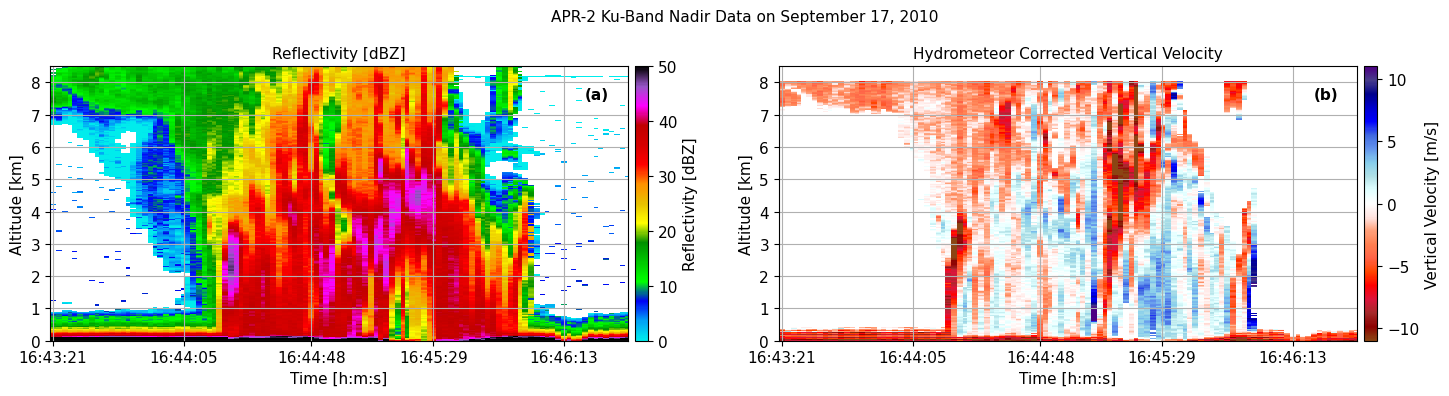

In [17]:
# Make manuscript figure

fig = plt.figure(figsize=(15, 4))
plt.suptitle('APR-2 Ku-Band Nadir Data on September 17, 2010', fontsize=11)

ax1 = plt.subplot(121)
ax1.set_title('Reflectivity [dBZ]', fontsize=11)
c1 = ax1.pcolormesh(meshx, meshy, dbz14, vmin=0, vmax=50, cmap='pyart_NWSRef')
cbar1 = plt.colorbar(c1, ax=ax1, pad=0.01)
cbar1.ax.tick_params(labelsize=11)
cbar1.ax.set_ylabel('Reflectivity [dBZ]', fontsize=11)
ax1.set_ylabel('Altitude [km]', fontsize=11)
ax1.set_xlabel('Time [h:m:s]', fontsize=11)
ax1.set_ylim(0, 8.5)
ax1.set_yticks(np.arange(0, 8.5, 1), (np.arange(0, 8.5, 1, dtype=int)))
Ticks = np.array(np.round(np.linspace(0, len(Distance)-1, 10)), dtype=int)
Ticks = Ticks[0:-1]
ax1.set_xticks(AdjustedTime[Ticks[::2]], ['16:43:21', '16:44:05', '16:44:48', '16:45:29', '16:46:13'])
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
plt.text(AdjustedTime[-9], 7.5, '(a)', fontsize = 11, weight='bold')
ax1.grid(True)

ax2 = plt.subplot(122)
ax2.set_title('Hydrometeor Corrected Vertical Velocity', fontsize=11)
c2 = ax2.pcolormesh(meshx, meshy, CorrectedVelocity, vmin=-11, vmax=11, cmap=cmap_Rdiff)
cbar2 = plt.colorbar(c2, ax=ax2, pad=0.01)
cbar2.ax.tick_params(labelsize=11)
cbar2.ax.set_ylabel('Vertical Velocity [m/s]', fontsize=11)
ax2.set_ylabel('Altitude [km]', fontsize=11)
ax2.set_xlabel('Time [h:m:s]', fontsize=11)
ax2.set_ylim(0, 8.5)
ax2.set_yticks(np.arange(0, 8.5, 1), (np.arange(0, 8.5, 1, dtype=int)))
Ticks = np.array(np.round(np.linspace(0, len(Distance)-1, 10)), dtype=int)
Ticks = Ticks[0:-1]
ax2.set_xticks(AdjustedTime[Ticks[::2]], ['16:43:21', '16:44:05', '16:44:48', '16:45:29', '16:46:13'])
ax2.tick_params(axis='y', labelsize=11)
ax2.tick_params(axis='x', labelsize=11)
plt.text(AdjustedTime[-9], 7.5, '(b)', fontsize = 11, weight='bold')
ax2.grid(True)

fig.tight_layout()
plt.savefig('/Users/hvagasky/Python/PMM_Hail/Figures/Manuscript/Figure3.png', facecolor='white', dpi=300)
plt.show()
